In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# TODO

In [99]:
import pickle

PICKLE_PATH = "allocine_dataset/data/allocine_dataset.pickle"

with open(PICKLE_PATH, 'rb') as reader:
    data = pickle.load(reader)

# Reviews need to be tokenized
train_reviews = np.array(data["train_set"]['review'])
val_reviews = np.array(data["val_set"]['review'])
test_reviews = np.array(data["test_set"]['review'])
all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

y_train = np.array(data["train_set"]['polarity'])
y_val = np.array(data["val_set"]['polarity'])
y_test = np.array(data["test_set"]['polarity'])
class_names = data['class_names']

In [80]:
train_reviews = train_reviews[:3000]
val_reviews = val_reviews[:3000]
y_train = y_train[:3000]
y_val = y_val[:3000]

In [81]:
from transformers import CamembertTokenizer

model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [82]:
some_review = train_reviews[2]
some_review

'Gros déception ! Je ne comprends pas pourquoi adapter un livre si pour ne pas en tenir compte. Le côté "histoire" n\'est pas exploité, la fin n\'a plus rien avoir avec le livre... Ils nous avaient déjà gâcher la fin d\'anges & demons, mais la vraiment on se demande pourquoi cette adaptation. Fan du livre passez votre chemin'

In [83]:
tokenizer.tokenize(some_review)

['▁Gros',
 '▁déception',
 '▁!',
 '▁Je',
 '▁ne',
 '▁comprends',
 '▁pas',
 '▁pourquoi',
 '▁adapter',
 '▁un',
 '▁livre',
 '▁si',
 '▁pour',
 '▁ne',
 '▁pas',
 '▁en',
 '▁tenir',
 '▁compte',
 '.',
 '▁Le',
 '▁côté',
 '▁"',
 'histoire',
 '"',
 '▁n',
 "'",
 'est',
 '▁pas',
 '▁exploité',
 ',',
 '▁la',
 '▁fin',
 '▁n',
 "'",
 'a',
 '▁plus',
 '▁rien',
 '▁avoir',
 '▁avec',
 '▁le',
 '▁livre',
 '...',
 '▁Ils',
 '▁nous',
 '▁avaient',
 '▁déjà',
 '▁gâcher',
 '▁la',
 '▁fin',
 '▁d',
 "'",
 'ange',
 's',
 '▁&',
 '▁de',
 'mons',
 ',',
 '▁mais',
 '▁la',
 '▁vraiment',
 '▁on',
 '▁se',
 '▁demande',
 '▁pourquoi',
 '▁cette',
 '▁adaptation',
 '.',
 '▁Fan',
 '▁du',
 '▁livre',
 '▁passez',
 '▁votre',
 '▁chemin']

In [9]:
tokenizer.encode(some_review)

[5,
 5507,
 10480,
 83,
 100,
 45,
 4312,
 34,
 590,
 9426,
 23,
 510,
 86,
 24,
 45,
 34,
 22,
 1852,
 287,
 9,
 54,
 423,
 87,
 549,
 130,
 49,
 11,
 41,
 34,
 15130,
 7,
 13,
 259,
 49,
 11,
 55,
 40,
 254,
 190,
 42,
 16,
 510,
 57,
 436,
 63,
 917,
 235,
 24064,
 13,
 259,
 18,
 11,
 4104,
 10,
 537,
 8,
 13990,
 7,
 65,
 13,
 302,
 91,
 48,
 400,
 590,
 78,
 7696,
 9,
 10772,
 25,
 510,
 9797,
 75,
 1111,
 6]

In [84]:
tokenizer.decode(tokenizer.encode(some_review))

'<s> Gros déception! Je ne comprends pas pourquoi adapter un livre si pour ne pas en tenir compte. Le côté "histoire" n\'est pas exploité, la fin n\'a plus rien avoir avec le livre... Ils nous avaient déjà gâcher la fin d\'anges & demons, mais la vraiment on se demande pourquoi cette adaptation. Fan du livre passez votre chemin</s>'

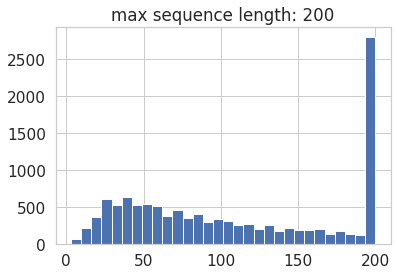

In [93]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text, max_length=200))
                          for text in train_reviews]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");


In [14]:
tokenizer.vocab_size

32005

In [100]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [101]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence, max_length=max_length)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}


encoded_train = encode_dataset(tokenizer, train_reviews, 200)
encoded_train["input_ids"]

array([[    5,    87,   243, ...,    33,    17,     6],
       [    5,  5897,    49, ...,  7490,     9,     6],
       [    5,  5507, 10480, ...,     0,     0,     0],
       ...,
       [    5,  5326,  2534, ...,     0,     0,     0],
       [    5,  5897,     8, ...,     0,     0,     0],
       [    5,   746,   221, ...,     0,     0,     0]], dtype=int32)

In [102]:
encoded_valid = encode_dataset(tokenizer, val_reviews, 200)
encoded_test = encode_dataset(tokenizer, test_reviews, 200)

In [72]:
from transformers import TFCamembertModel
from tensorflow.keras.layers import Dropout, Dense, Activation


class ClassificationModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, model_name="jplu/tf-camembert-base",
                 dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFCamembertModel.from_pretrained(model_name)
        
        # Classification head
        self.dropout_1 = tf.keras.layers.Dropout(dropout_prob)
        #self.linear_1 = tf.keras.layers.Dense(768)
        #self.activation = tf.keras.layers.Activation('tanh')
        #self.dropout_2 = tf.keras.layers.Dropout(dropout_prob)
        self.linear_2 = tf.keras.layers.Dense(2)

    def call(self, inputs, **kwargs):
        sequence_output, pooled_output = self.bert(inputs, **kwargs)

        x = self.dropout_1(pooled_output, training=kwargs.get("training", False))        
        #x = self.linear_1(x)
        #x = self.activation(x)
        #x = self.dropout_2(x, training=kwargs.get("training", False))
        logits = self.linear_2(x)
        return logits

# TODO: see https://huggingface.co/transformers/v2.1.1/_modules/transformers/modeling_tf_roberta.html#TFRobertaForSequenceClassification
intent_model = ClassificationModel()

In [73]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)    
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

intent_model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [96]:
from transformers import TFCamembertForSequenceClassification

model = TFCamembertForSequenceClassification.from_pretrained("jplu/tf-camembert-base")

opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)    

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [97]:
model.summary()

Model: "tf_camembert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  110621952 
_________________________________________________________________
classifier (TFRobertaClassif multiple                  592130    
Total params: 111,214,082
Trainable params: 111,214,082
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Trained with max length = 200, val_accuracy = 0.9489 after 2 epochs
history = model.fit(
    encoded_train, y_train, epochs=10, batch_size=8, 
    validation_data=(encoded_valid, y_val), verbose=1
)

Train on 12000 samples, validate on 4000 samples
Epoch 1/10
12000/12000 [==============================] - 569s 47ms/sample - loss: 0.2662 - accuracy: 0.8785 - val_loss: 0.1659 - val_accuracy: 0.9366
Epoch 2/10
12000/12000 [==============================] - 571s 48ms/sample - loss: 0.1176 - accuracy: 0.9565 - val_loss: 0.1431 - val_accuracy: 0.9489
Epoch 3/10
 1184/12000 [=>............................] - ETA: 7:47 - loss: 0.0858 - accuracy: 0.9707

KeyboardInterrupt: 

In [ ]:
y_train